In [51]:
import os
import time
import requests
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model, model_selection

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Subset
import torch.nn.functional as F

import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.models import resnet18

from tqdm.notebook import tqdm

import importlib

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device:", DEVICE.upper())

# manual random seed is used for dataset partitioning
# to ensure reproducible results across runs
RNG = torch.Generator().manual_seed(42)

# set num workers for loading data
NUM_WORKERS = 8

Running on device: CPU


In [43]:
# downloading and transforming MNIST

MNIST_MEAN = (0.5, )
MNIST_STD = (0.5, )

mnist_transform = transforms.Compose([transforms.ToTensor(),  # this will normalize each within [0, 1]
                                transforms.Normalize(MNIST_MEAN, MNIST_STD)]) # make data within [-1. 1]

MNIST_BATCH_SIZE = 256

mnist_train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=mnist_transform)
mnist_train_loader = torch.utils.data.DataLoader(mnist_train_set, batch_size=MNIST_BATCH_SIZE, shuffle=True)

mnist_test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=mnist_transform)
mnist_test_loader = torch.utils.data.DataLoader(mnist_test_set, batch_size=MNIST_BATCH_SIZE, shuffle=False)

In [54]:
# define image denormalizer
def denormalize(tensor: torch.Tensor, mean, std):
    """
    tensor can have multiple channels.
    In such case, mean and std should be lists with the same length as the channel number
    """
    # clone the tensor to avoid changes to the original data
    tensor = tensor.clone()
    # denormalize each channel
    for t, m, s in zip(tensor, mean, std):
        t = t.mul(s).add(m)  # out-of-place operation
    # clamp the values to ensure they're within [0, 1] range
    return tensor.clamp(0, 1)

MNIST image shape: torch.Size([1, 28, 28])


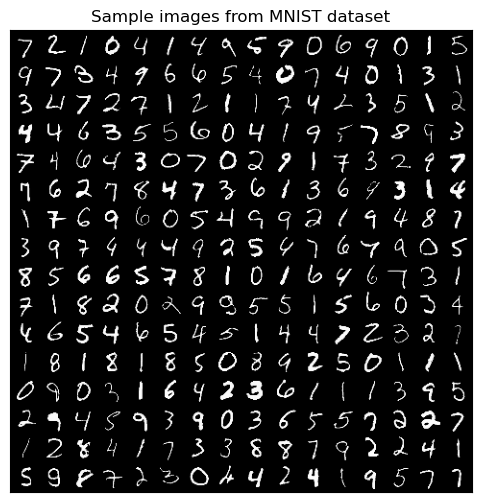

In [48]:
# print some images from MNIST just for fun
images, labels = next(iter(mnist_test_loader))
mnist_img_shape = images.shape[1:]
print(f"MNIST image shape: {mnist_img_shape}")

# denormalizing the images
images = denormalize(images, MNIST_MEAN, MNIST_STD)

fig, ax = plt.subplots(figsize=(12, 6))
plt.title("Sample images from MNIST dataset")
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
plt.show()

In [53]:
# define networks

# define LeNet for MNIST distillation
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)  # 1 input channel (grayscale), 6 output channels, 5x5 square convolution
        self.pool = nn.MaxPool2d(2, 2)   # Max pooling over a (2, 2) window
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)  # 16*4*4 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)  # 10 output classes for MNIST (digits 0-9)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)  # flatten the tensor for the fully connected layer
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
# define get_net
def get_net(name, init):
    if name == "lenet":
        net = LeNet()
    else:
        raise NotImplementedError()
    if init is None:
        pass
    elif init == "kaiming":
        for m in net.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    else:
        raise NotImplementedError()
    return net


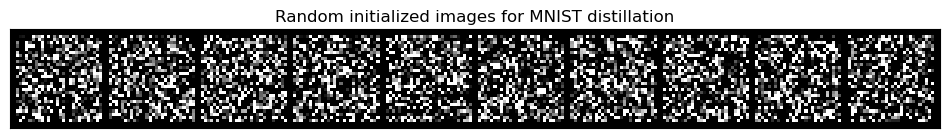

In [76]:
# define synthetic MNIST dataset
NUM_SAMPLES_PER_CLS = 10

num_classes_mnist = 10

# initialize random synth dataset
mnist_img_syn = torch.randn(size=(num_classes_mnist*NUM_SAMPLES_PER_CLS, *mnist_img_shape), dtype=torch.float, requires_grad=True, device=DEVICE)
mnist_lab_syn = torch.tensor(np.array([np.ones(NUM_SAMPLES_PER_CLS)*i for i in range(num_classes_mnist)]), dtype=torch.long, requires_grad=False, device=DEVICE).view(-1)


# denormalizing the images
images = denormalize(mnist_img_syn, MNIST_MEAN, MNIST_STD)

# print some of them
fig, ax = plt.subplots(figsize=(12, 6))
plt.title("Random initialized images for MNIST distillation")
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(make_grid(images, nrow=10).permute(1, 2, 0))
plt.show()

Distilling dataset using vanilla DD:   0%|          | 0/10000 [00:00<?, ?it/s]

Optimization iteration 0 evaluation begins...


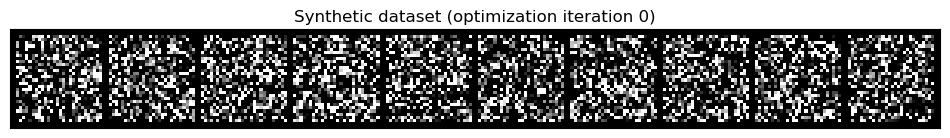

Optimization iteration 0, eval acc (train): 0.0356, eval acc (test): 0.0326
New best! Saving checkpoint iteration 0...
Checkpoint at iteration 0 saved at ./saved_data/imgdd/distilled_mnist.pth
New best! Saving checkpoint iteration 1...
Checkpoint at iteration 1 saved at ./saved_data/imgdd/distilled_mnist.pth
New best! Saving checkpoint iteration 2...
Checkpoint at iteration 2 saved at ./saved_data/imgdd/distilled_mnist.pth
New best! Saving checkpoint iteration 3...
Checkpoint at iteration 3 saved at ./saved_data/imgdd/distilled_mnist.pth
New best! Saving checkpoint iteration 4...
Checkpoint at iteration 4 saved at ./saved_data/imgdd/distilled_mnist.pth
New best! Saving checkpoint iteration 5...
Checkpoint at iteration 5 saved at ./saved_data/imgdd/distilled_mnist.pth
New best! Saving checkpoint iteration 6...
Checkpoint at iteration 6 saved at ./saved_data/imgdd/distilled_mnist.pth
New best! Saving checkpoint iteration 7...
Checkpoint at iteration 7 saved at ./saved_data/imgdd/distille

KeyboardInterrupt: 

In [78]:
# code for distilling dataset

# vanilla Dataset Distillation intends to get dataset that is able to train a model within only 1 epoch

DATASET = ["mnist", "cifar10"][0]

# define hyper params
NUM_OPTIM_IT = 10000
EVAL_INTERVAL = 500

INIT_LR = 0.001
MINIMUM_LR = 1e-5
STEP_SIZE = 0.001
INIT_WEIGHTS_DISTR = [None, "kaiming"][1]
FIX_INIT_WEIGHTS = True
NUM_SAMPLED_NETS_TRAIN = 16
NUM_SAMPLED_NETS_EVAL = 4
NUM_SAMPLES_PER_CLS = 10

# checkpoints saving
CHECKPOINT_SAVE_DIR = "./saved_data/imgdd/"
if not os.path.exists(CHECKPOINT_SAVE_DIR):
    os.makedirs(CHECKPOINT_SAVE_DIR)


# define local variables
if DATASET == "mnist":
    train_loader = mnist_train_loader
    test_loader = mnist_test_loader
    img_syn = mnist_img_syn
    lab_syn = mnist_lab_syn
    net_name = "lenet"
    pixel_mean, pixel_std = MNIST_MEAN, MNIST_STD
else:
    raise NotImplementedError()

# initialize learning rate
lr = torch.tensor([INIT_LR], dtype=torch.float, requires_grad=True, device=DEVICE) # make it learnable

optimizer_img = torch.optim.Adam([img_syn], lr=STEP_SIZE)
optimizer_lr = torch.optim.Adam([lr], lr=STEP_SIZE)

loss_fn = torch.nn.CrossEntropyLoss()

# data used for plotting curves
optim_losses = [] # optimization objective loss each iteration
min_optim_loss = float('inf')
syn_lrs = [] # synthetic lr
eval_accs_train = [] # evaluation accuracy on train set
eval_accs_test = [] # evaluation accuracy on test set

# define fuctions
def accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    # compare with the true labels and count the correct ones
    correct = (predicted == labels).sum().item()
    # calculate the accuracy
    acc = correct / labels.size(0)
    return acc

def overall_accuracy(net, dataloader):
    net.eval()
    sum_acc = 0
    sum_w = 0
    with torch.no_grad():
        for i, (imgs, labs) in enumerate(dataloader):
            outputs = net(imgs)
            local_acc = accuracy(outputs, labs)
            sum_acc += local_acc * len(imgs)
            sum_w += len(imgs)
    return sum_acc / sum_w


# begin training steps
pbar = tqdm(range(NUM_OPTIM_IT), desc="Distilling dataset using vanilla DD")
for it in pbar:
    # get a minibatch of real training data
    if 'train_loader_iter' not in locals() or train_loader_iter._num_yielded == len(train_loader):
        train_loader_iter = iter(train_loader)
    
    img_real, lab_real = next(train_loader_iter)

    # evaluate the distilled data every `EVAL_INTERVAL` iterations
    if it % EVAL_INTERVAL == 0:
        print(f"Optimization iteration {it} evaluation begins...")
        img_syn_checkpoint = img_syn.detach().clone()
        # lab_syn are not learning objectives so just use it in-place
        lr_checkpoint = lr.detach().clone()

        # print the images
        images = denormalize(img_syn_checkpoint, pixel_mean, pixel_std)
        fig, ax = plt.subplots(figsize=(12, 6))
        plt.title(f"Synthetic dataset (optimization iteration {it})")
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=10).permute(1, 2, 0))
        plt.show()

        # sample a batch of models to eval on
        sampled_nets = []
        local_train_accs = []
        local_test_accs = []
        for j in range(NUM_SAMPLED_NETS_EVAL):
            if FIX_INIT_WEIGHTS:
                torch.random.manual_seed(42) # fixed seed
            else:
                torch.random.manual_seed(int(time.time() * 1000) % 100000) # random seed
            net = get_net(net_name, INIT_WEIGHTS_DISTR).to(DEVICE)
            sampled_nets.append(net)
        for net in sampled_nets:
            net.train()
            optimizer = torch.optim.SGD(net.parameters(), lr=lr_checkpoint.item())
            # train the models on synthetic set
            pred_syn = net(img_syn_checkpoint)
            loss_syn = loss_fn(pred_syn, lab_syn)
            optimizer.zero_grad()
            loss_syn.backward()
            optimizer.step()
        for net in sampled_nets:
            # evaluate the models on both full train set and test set
            train_acc = overall_accuracy(net, train_loader)
            test_acc = overall_accuracy(net, test_loader)
            local_train_accs.append(train_acc)
            local_test_accs.append(test_acc)
        eval_accs_train.append(sum(local_train_accs) / len(local_train_accs))
        eval_accs_test.append(sum(local_test_accs) / len(local_test_accs))
        print(f"Optimization iteration {it}, eval acc (train): {eval_accs_train[-1]:.4f}, eval acc (test): {eval_accs_test[-1]:.4f}")
    
    # sample a batch of models
    sampled_nets = []
    for j in range(NUM_SAMPLED_NETS_TRAIN):
        if FIX_INIT_WEIGHTS:
            torch.random.manual_seed(42) # fixed seed
        else:
            torch.random.manual_seed(int(time.time() * 1000) % 100000) # random seed
        net = get_net(net_name, INIT_WEIGHTS_DISTR).to(DEVICE)
        sampled_nets.append(net)
        
    optimizer_img.zero_grad()
    optimizer_lr.zero_grad()

    losses = []
    for net in sampled_nets:
        # Step 1: Train each sampled model on synthetic dataset
        net.train()
        pred_syn = net(img_syn)
        loss_syn = loss_fn(pred_syn, lab_syn)
        
        for m in net.modules():
            param_names = []
            new_params = []
            for n, p in m.named_parameters(recurse=False): # n is the param's name alone instead of "module.name"
                gp, = torch.autograd.grad(loss_syn, p, create_graph=True) # enabling higher-order derivatives
                new_p = p - lr * gp
                new_p.to(DEVICE)
                param_names.append(n) # save them, to delete leaf params later in another enumeration
                new_params.append(new_p) # save them, to reset non-leaf params later in another enumeration
            for i, n in enumerate(param_names):
                delattr(m, n)
                setattr(m, n, new_params[i])

        # Step 2: Evaluate the objective function on real training data
        pred_real = net(img_real)
        loss_real = loss_fn(pred_real, lab_real)
        losses.append(loss_real)

        # Clear gradients for the next model
        net.zero_grad()

    # Check if params are swapped as non-leaves
    # for model in sampled_models:
    #     for m in model.modules():
    #         for n, p in m.named_parameters(recurse=False): # name is the param's name alone instead of module.name
    #             print(p.grad_fn)
    
    # Step 3: Update synthetic data and learnable learning rate
    total_loss = sum(losses)
    total_loss.backward()  # Compute gradients based on real data losses

    # Update synthetic data and learning rate
    # print(lr.grad) # shouldn't be none
    # print(img_syn.grad) # shouldn't be none
    optimizer_img.step()
    optimizer_lr.step()

    # lr can't be negative
    if lr.item() < MINIMUM_LR:
        lr.data = MINIMUM_LR

    # Logging the progress
    pbar.set_postfix({"loss": f"{total_loss.item():.4f}",
                      "learnable lr": f"{lr.item()}",
                      })
    optim_losses.append(total_loss.item())
    syn_lrs.append(lr.item())

    if total_loss.item() < min_optim_loss or it >= NUM_OPTIM_IT - 1: # save checkpoint
        min_optim_loss = total_loss.item()
        print(f"New best! Saving checkpoint iteration {it}...")
        checkpoint = {
            "it": it,
            "img_syn": img_syn.detach().clone(),
            "lab_syn": lab_syn.detach().clone(),
            'optim_losses': optim_losses,
            'syn_lrs': syn_lrs,
            'eval_accs_train': eval_accs_train,
            'eval_accs_test': eval_accs_test,
        }
        # Save checkpoint
        filepath = os.path.join(CHECKPOINT_SAVE_DIR, f'distilled_{DATASET}.pth')
        torch.save(checkpoint, filepath)
        print(f"Checkpoint at iteration {it} saved at {filepath}")
    

In [ ]:
# distill with matching loss

DATASET = ["mnist", "cifar10"][0]

# define local variables
if DATASET == "mnist":
    train_loader = mnist_train_loader
    test_loader = mnist_test_loader
    img_syn = mnist_img_syn
    lab_syn = mnist_lab_syn
    net_name = "lenet"
    pixel_mean, pixel_std = MNIST_MEAN, MNIST_STD
    num_cls = 10
else:
    raise NotImplementedError()

# define hyper params
TRAIN_IT = 100
EVAL_INTERVAL = -1
EVAL_NUM_EPOCHS = 50
NUM_SAMPLED_MODELS_EVAL = 4
LR_DATA = 0.01
LR_NET = 0.01
NUM_OUTER_LOOP = 10
NUM_INNER_LOOP = 5
REAL_BATCH_SIZE = 256
SYN_BATCH_SIZE = 256

N_SAMPLES_PER_CLS = 10
INIT_WEIGHTS_DISTR = None

# define training optimizers and criterion
optimizer_img = torch.optim.SGD([img_syn,], lr=LR_DATA, momentum=0.5) # optimizer for synthetic data
optimizer_img.zero_grad()
criterion = nn.CrossEntropyLoss()
print("Ready for training")

# data for plotting curves
eval_accs_train = [] # evaluation accuracy on train set
eval_accs_test = [] # evaluation accuracy on test set
avg_losses = []
min_avg_loss = float('inf')

SYN_DATA_SAVE_DIR = "./saved_data/imgdd/"
if not os.path.exists(SYN_DATA_SAVE_DIR):
    os.makedirs(SYN_DATA_SAVE_DIR)
pbar = tqdm(range(TRAIN_IT), desc="Training iteration")
for it in pbar:

    # evaluate the distilled data every `EVAL_INTERVAL` iterations
    if it % EVAL_INTERVAL == 0:
        print(f"Optimization iteration {it} evaluation begins...")
        img_syn_checkpoint = img_syn.detach().clone()
        # lab_syn are not learning objectives so just use it in-place
        lr_checkpoint = lr.detach().clone()

        # print the images
        images = denormalize(img_syn_checkpoint, pixel_mean, pixel_std)
        fig, ax = plt.subplots(figsize=(12, 6))
        plt.title(f"Synthetic dataset (optimization iteration {it})")
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=10).permute(1, 2, 0))
        plt.show()

        # sample a batch of models to eval on
        sampled_nets = []
        local_train_accs = []
        local_test_accs = []
        for j in range(NUM_SAMPLED_NETS_EVAL):
            torch.random.manual_seed(int(time.time() * 1000) % 100000) # random seed
            # torch.random.manual_seed(42) # fixed seed
            net = get_net(net_name, INIT_WEIGHTS_DISTR).to(DEVICE)
            sampled_nets.append(net)
        for net in sampled_nets:
            net.train()
            optimizer = torch.optim.SGD(net.parameters(), lr=lr_checkpoint.item())
            # train the models on synthetic set
            pred_syn = net(img_syn_checkpoint)
            loss_syn = loss_fn(pred_syn, lab_syn)
            optimizer.zero_grad()
            loss_syn.backward()
            optimizer.step()
        for net in sampled_nets:
            # evaluate the models on both full train set and test set
            train_acc = overall_accuracy(net, train_loader)
            test_acc = overall_accuracy(net, test_loader)
            local_train_accs.append(train_acc)
            local_test_accs.append(test_acc)
        eval_accs_train.append(sum(local_train_accs) / len(local_train_accs))
        eval_accs_test.append(sum(local_test_accs) / len(local_test_accs))
        print(f"Optimization iteration {it}, eval acc (train): {eval_accs_train[-1]:.4f}, eval acc (test): {eval_accs_test[-1]:.4f}")
    

    # Train synthetic data
    torch.random.manual_seed(int(time.time() * 1000) % 100000) # random init network
    net = get_net(net_name, INIT_WEIGHTS_DISTR).to(DEVICE)
    net.train()
    net_params = list(net.parameters())

    optimizer_net = torch.optim.SGD(net.parameters(), lr=LR_NET)
    optimizer_net.zero_grad()
    loss_avg = 0

    for ol in range(NUM_OUTER_LOOP):
        # update synthetic data
        loss = torch.tensor(0.0).to(DEVICE)
        for cls in (0, 1):
            ts_real, lab_real = train_set.random_sample_from_class(n_samples=REAL_BATCH_SIZE, cls=cls, no_duplicate=True)
            ts_real, lab_real = ts_real.to(DEVICE), lab_real.to(DEVICE)
            ts_syn = episodes_syn[cls*N_SAMPLES_PER_CLS: (cls+1)*N_SAMPLES_PER_CLS]
            lab_syn = labels_syn[cls*N_SAMPLES_PER_CLS: (cls+1)*N_SAMPLES_PER_CLS]

            out_real = net(ts_real)
            loss_real = criterion(out_real, lab_real)
            grad_real = torch.autograd.grad(loss_real, net_params)
            grad_real = [_.detach().clone() for _ in grad_real]

            out_syn = net(ts_syn)
            loss_syn = criterion(out_syn, lab_syn)
            grad_syn = torch.autograd.grad(loss_syn, net_params, create_graph=True) # create_graph: will be used to compute higher-order derivatives

            # compute gradient matching loss, here using MSE, instead of the one proposed in DCwMG because it's too complicated
            # dis = torch.tensor(0.0).to(DEVICE)
            grad_real_vec = []
            grad_syn_vec = []
            for ig in range(len(grad_real)):
                grad_real_vec.append(grad_real[ig].reshape((-1)))
                grad_syn_vec.append(grad_syn[ig].reshape((-1)))
            grad_real_vec = torch.cat(grad_real_vec, dim=0)
            grad_syn_vec = torch.cat(grad_syn_vec, dim=0)
            dis = torch.sum((grad_syn_vec - grad_real_vec)**2)

            loss += dis
        
        optimizer_img.zero_grad()
        loss.backward()
        optimizer_img.step()
        loss_avg += loss.item()

        if ol == NUM_OUTER_LOOP - 1:
            break

        # update network
        episodes_syn_train, labels_syn_train = copy.deepcopy(episodes_syn.detach()), copy.deepcopy(labels_syn.detach())  # avoid any unaware modification
        syn_dataset = dataset.TensorDataset(episodes_syn_train, labels_syn_train)
        syn_loader = DataLoader(syn_dataset, SYN_BATCH_SIZE, shuffle=True)
        for il in range(NUM_INNER_LOOP):
            train.epoch("train", syn_loader, net, criterion, optimizer=optimizer_net)

    loss_avg /= (2 * NUM_OUTER_LOOP)
    pbar.set_postfix({"avg loss": f"{loss_avg:.4f}",
                      })
    avg_losses.append(loss_avg)
    if loss_avg < min_avg_loss:
        min_avg_loss = loss_avg

    torch.save({"data": (copy.deepcopy(episodes_syn.detach().cpu()), copy.deepcopy(labels_syn.detach().cpu())),
                "size": (2*N_SAMPLES_PER_CLS, input_shape[0], input_shape[1]),
                },
            os.path.join(SYN_DATA_SAVE_DIR, f"mg_{MODEL}_it{it}_avgl{loss_avg:.4f}.pt")
            )

